# LHC collimation study

In [1]:
import numpy as np
from pathlib import Path

import xobjects as xo
import xtrack as xt
import xcoll as xc

### Import a line

In [2]:
line = xt.Line.from_json(f'lhc_run3_b1.json')

Loading line from dict:   0%|          | 0/102795 [00:00<?, ?it/s]

Done loading line from dict.           


### Install and configure collimators using `xcoll`

In [3]:
coll_manager = xc.CollimatorManager.from_yaml('collimators_simplified.yaml', line=line, beam='1')
coll_manager.install_everest_collimators(verbose=True)

Installing tcp.6l3.b1           as EverestCollimator
Installing tcsg.5l3.b1          as EverestCollimator
Installing tcsg.4r3.b1          as EverestCollimator
Installing tctph.4l5.b1         as EverestCollimator
Installing tctpv.4l5.b1         as EverestCollimator
Installing tcp.d6l7.b1          as EverestCollimator
Installing tcp.c6l7.b1          as EverestCollimator
Installing tcsg.b5l7.b1         as EverestCollimator
Installing tcspm.b4l7.b1        as EverestCollimator
Installing tctph.4l1.b1         as EverestCollimator
Installing tctpv.4l1.b1         as EverestCollimator


#### Aperture sanity check

In [4]:
df_with_coll = line.check_aperture()

Checking aperture:   0%|          | 0/102742 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


#### Build tracker

In [5]:
coll_manager.build_tracker()

Found suitable prebuilt kernel `default_xcoll`.


#### Set collimators gaps (optics computed internally)

In [6]:
coll_manager.set_openings()

/Users/giadarol/xsuite_packages/xcoll/xcoll/manager.py:515: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.colldb._optics = pd.concat([


#### Simulate impact of a pencil beam on the jows of a given collimator

In [7]:
# Generate distribution
tcp  = 'tcp.c6l7.b1'
part = coll_manager.generate_pencil_on_collimator('tcp.c6l7.b1', num_particles=int(5e4))

Collimator tcp.c6l7.b1 is converging.


In [8]:
# Switch to multicore context
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [9]:
# Track
coll_manager.enable_scattering()
line.track(part, num_turns=30, time=True, with_progress=2)


Tracking:   0%|          | 0/30 [00:00<?, ?it/s]

#### Analysis of tracking results - loss maps

In [10]:
# Disable scattering and multi-core parallilization
coll_manager.disable_scattering()
line.discard_tracker()
line.build_tracker(_context=xo.context_default)

Found suitable prebuilt kernel `default_xcoll`.


In [11]:
coll_manager.lossmap(part, file='mylossmap.json');

Performing the aperture losses refinement.
Found suitable prebuilt kernel `default_xcoll`.
Found suitable prebuilt kernel `default_xcoll_no_limit`.
Found suitable prebuilt kernel `default_xcoll_backtrack_no_limit`.


#### Plot (same tool as for measured loss-map)

In [12]:
import lossmaps as lm

lmap = lm.SimulatedLossMap(lmtype=lm.LMType['B1H'], machine=lm.Machine.LHC, energy=6800, particle=lm.Particle.PROTON)
lmap.load_data_json(json_files='mylossmap.json')

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.
Maximum inefficiency in the DS is 0.000787.


Warning, `show_layout` temporarily not supported.


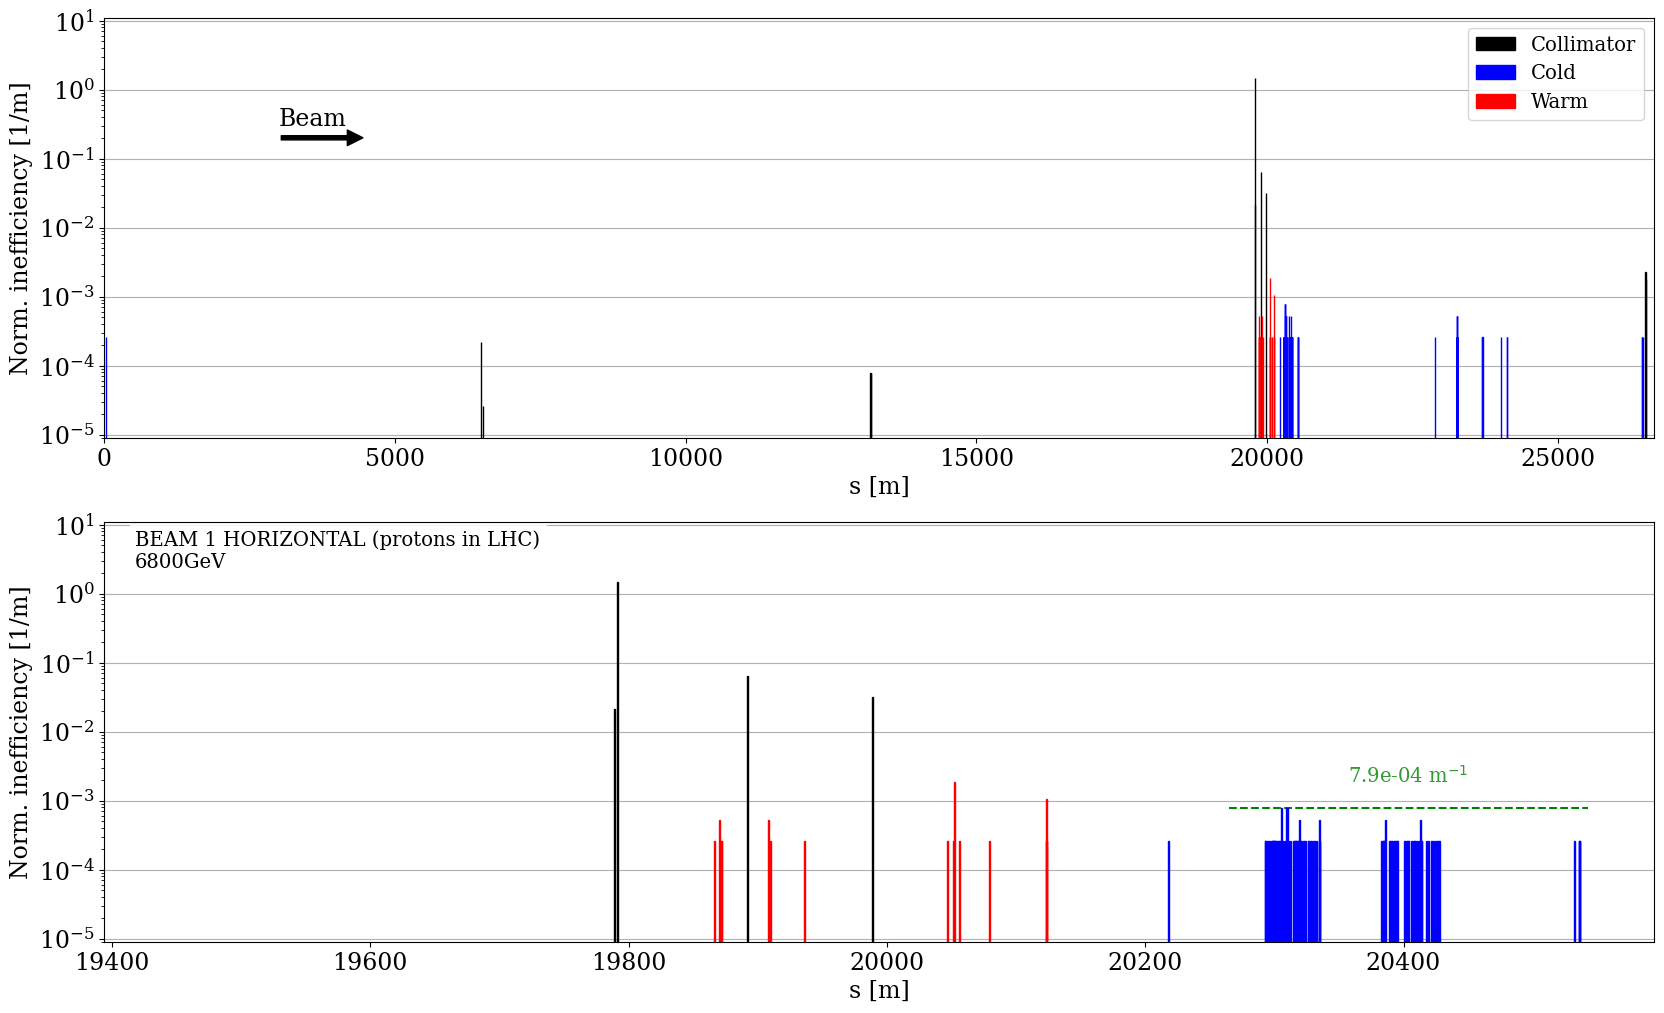

In [13]:
# Plot the loss map
_ = lm.plot_lossmap(lmap)